In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torchvision
import cv2
from skimage import io, transform
import pickle
import random
import torch.nn.functional as F

In [2]:
class DeviceDict(dict):
        def __init__(self, *args):
            super(DeviceDict, self).__init__(*args)

        def to(self, device):
            dd = DeviceDict()
            for k, v in self.items():
                if torch.is_tensor(v):
                    dd[k] = v.to(device)
                else:
                    dd[k] = v
            return dd

In [3]:
species = ["resident", "transient"]

class Killer_Whale_Dataset(Dataset):
    def __init__(self, data_folder, transform = None):
        super().__init__()
        self.transform = transform
        if os.path.exists("data/data.npy"):
            self.data = np.load("data/data.npy", allow_pickle=True)
        else:
            self.img_list, self.mask_list = Killer_Whale_Dataset._load_dataset(data_folder)
            self.img_list.sort(key=lambda x: x["path"])
            self.mask_list.sort(key=lambda x: x["path"])
            self.img_list, self.mask_list = Killer_Whale_Dataset._remove_grayscale(self.img_list, self.mask_list)
            self.data = Killer_Whale_Dataset.merge_masks_and_imgs(self.img_list, self.mask_list)
            random.shuffle(self.data)
            np.save("data/data.npy", self.data)

    def __getitem__(self, idx):
        elt = self.data[idx]

        img_array = elt["img"]
        species_array = elt["species"]
        mask_array = elt["mask"]
        if self.transform:
            img_array = self.transform(img_array)
            mask_array = self.transform(mask_array)
       
        return DeviceDict({"img": img_array, 
                "id": elt["id"], 
                "species": species_array,
                "mask": mask_array}) 

    def __len__(self):
        return len(self.data)

    @staticmethod
    def _remove_grayscale(img_list, mask_list):
        indices = []
        for i, img in enumerate(img_list):
            num_channels = img["img"].mode
            if num_channels != "RGB":
                indices.append(i)
        img_list = np.delete(img_list, indices)
        mask_list = np.delete(mask_list, indices)
        return img_list, mask_list

    @staticmethod 
    def _load_dataset(path):
        imgs = []
        masks = []
        for subdir, dirs, files in os.walk(path):
            for f in files:
                whale = {}
                filepath = subdir + "/" + f
                #print(filepath)
                # There is no mask for picture KW6CA171B_6.jpg so skip it for now
                if "KW6CA171B_6.jpg" in filepath:
                    continue
                
                id = torch.tensor(float(filepath.split("/")[2][-3:]))
                species =  filepath.split("/")[1]
                img_or_mask = filepath.split("/")[3]
            
                whale["id"] = id
                whale["path"] = filepath

                if "resident" in species:
                    whale["species"] = 0
                elif "transient" in species:
                    whale["species"] = 1

                img = Image.open(filepath)
                #img = img.resize((400, 400))
                img = img.resize((224, 224)) 
                if img_or_mask == "img" or img_or_mask == "IMG":
                    whale["img"] = img 
                    imgs.append(whale)
                elif img_or_mask == "mask":
                    whale["mask"] = img
                    masks.append(whale)
        
        return imgs, masks 

    @staticmethod
    def merge_masks_and_imgs(img_list, mask_list):
        data = []
        for i, val in enumerate(img_list):
            mask = mask_list[i]["mask"]
            val["mask"] = mask
            data.append(val)
        return data
    
    

In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# whale_path = 'data/'

# whale_data = Killer_Whale_Dataset(whale_path, transform=transform)
# #print(whale_data.__len__())
# print(type(whale_data[0]['id']))

In [5]:
def Tensor2Image(t):
    trans = transforms.ToPILImage()
    img = trans(t[0,:,:,:])
    return img



class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        
        
        ## this is for 600*600 size image
        #self.conv2a = nn.Conv2d(in_channels=3, out_channels=128,kernel_size=#,stride = 3)
        self.conv2a = nn.Conv2d(in_channels=3, out_channels=80,kernel_size=4,stride = 3)
        
        self.conv2b = nn.Conv2d(in_channels=80, out_channels=80,kernel_size=4,stride = 2)

        # self.conv2c = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        # self.conv2d = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        # self.conv2e = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        # self.conv2f = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        self.pool = nn.MaxPool2d(3, 3)
        
        ## this is for 600*600 size image    
        #self.fc1a = nn.Linear(128*10*10,80)
        ## this is for 224*224 size image
        self.fc1a = nn.Linear(80*3*3,80)
        self.fc1b = nn.Linear(80,40)

        self.fc2a = nn.Linear(40,80)
        self.fc2b = nn.Linear(80,80*11*11)
        #self.fc2c = nn.Linear(128,3*224*224)
        self.convtrans2a = nn.ConvTranspose2d(in_channels=80, out_channels=80,kernel_size=4,stride = 2)
        self.convtrans2b = nn.ConvTranspose2d(in_channels=80, out_channels=80,kernel_size=4,stride = 3)
        self.convtrans2c = nn.ConvTranspose2d(in_channels=80, out_channels=3,kernel_size=8,stride = 3)
        self.convtrans2d = nn.ConvTranspose2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        self.convtrans2e = nn.ConvTranspose2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        self.convtrans2f = nn.ConvTranspose2d(in_channels=128, out_channels=128,kernel_size=3,stride = 2)
        self.convtrans2g = nn.ConvTranspose2d(in_channels=128, out_channels=3,kernel_size=4,stride = 2)
        
        ## Here, we should define some smart layers
    def encode(self, dictionary):
        ## Use Deep NN to encode the image

        x = dictionary['img']
        batch_size = x.shape[0]
        
        e1 = nn.ReLU()(self.conv2a(x))
        j1 = self.pool(e1)
        e2 = nn.ReLU()(self.conv2b(j1))
        j2 = self.pool(e2)
        # e3 = nn.ReLU()(self.conv2c(e2))
        # e4 = nn.ReLU()(self.conv2d(e3))
        # e5 = nn.ReLU()(self.conv2e(e4))
        # e6 = nn.ReLU()(self.conv2f(e5))
        
        j2 = self.pool(e2)
        
        #print(e2.size())
        k1 = j2.view(batch_size,-1)
        k2 = nn.ReLU()(self.fc1a(k1))
        latent_info = self.fc1b(k2)
        return latent_info
    
    def decode(self, latent_info):


        ## use the NN to decode to mask
        batch_size = latent_info.shape[0]
        
        h1 = nn.ReLU()(self.fc2a(latent_info))
        h2 = nn.ReLU()(self.fc2b(h1))
        # h3 = self.fc2c(h2)
        
        ## this is for 600*600 size image       
        #y = h3.view(batch_size,-1,600,600)
        
        y = h2.view(batch_size,-1,11,11)

        d1 = nn.ReLU()(self.convtrans2a(y))
        
        d2 = nn.ReLU()(self.convtrans2b(d1))
        d3 = self.convtrans2c(d2)
        #print(d3.size())
        # d3 = nn.ReLU()(self.convtrans2c(d2))
        
        # d4 = nn.ReLU()(self.convtrans2d(d3))
        # d5 = nn.ReLU()(self.convtrans2e(d4))
        # d6 = nn.ReLU()(self.convtrans2f(d5))
        # d7 = self.convtrans2g(d6)
        
        
        
        return {'img': d3}

    def forward(self, dictionary):
        latent_info = self.encode(dictionary)        
        poly_dict = self.decode(latent_info)
        return poly_dict

In [6]:
transform = transforms.Compose([transforms.ToTensor()])   

whale_path = 'data/'


whale_data = Killer_Whale_Dataset(whale_path,transform = transform)

data_len = len(whale_data)
#data_len = int(0.1*data_len)
val_len = int(0.1*data_len)
x = list(range(0,data_len))
ind_val = random.choices(x, k=val_len)
ind_train = list(set(x).difference(set(ind_val)))



val_set = torch.utils.data.Subset(whale_data,ind_val)
train_set = torch.utils.data.Subset(whale_data,ind_train)


train_loader = torch.utils.data.DataLoader(train_set,batch_size = 5,shuffle = True,drop_last = False)
val_loader = torch.utils.data.DataLoader(val_set,batch_size = 1,shuffle = True,drop_last = False)




FileNotFoundError: [Errno 2] No such file or directory: 'data/data.npy'

In [ ]:
class Orca_Classify(nn.Module):
    def __init__(self):
        super(Orca_Classify, self).__init__()
        
        
        
        
        self.fc1 = nn.Linear(40 , 100)
        self.fc2 = nn.Linear(100, 40)
        self.fc3 = nn.Linear(40,1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, latent_info):
        #print(latent_info.size())
        batch_size = latent_info.shape[0]
        x = nn.ReLU()(self.fc1(latent_info))
        x = nn.ReLU()(self.fc2(x))
        #x = nn.LeakyReLU()(self.fc3(x))
        #x = x.view(batch_size,-1)
        #x = x.squeeze()
        #x = self.softmax(x)
        #print(x)
        return {"id": x}

In [7]:
detection = AE()
detection.load_state_dict(torch.load('./para/weight/para_224_adam.pt'))

Classification = Orca_Classify()

optimizer = torch.optim.Adam(Classification.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(detection.parameters(), lr=0.01,momentum = 0.9)
losses = []
losses_mean=[]
valError = []

FileNotFoundError: [Errno 2] No such file or directory: './para/weight/para_224_adam.pt'

NameError: name 'train_loader' is not defined

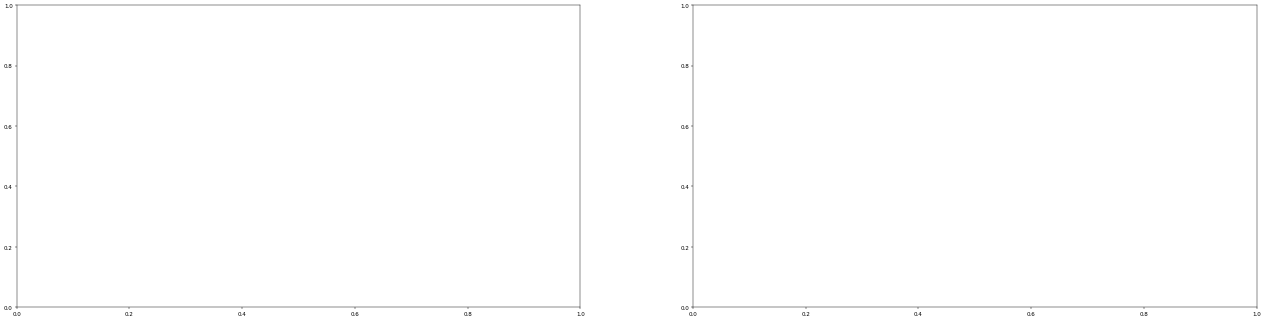

In [8]:
from IPython import display
import statistics
fig=plt.figure(figsize=(40, 10), dpi= 40, facecolor='w', edgecolor='k')
axes=fig.subplots(1,2)

for epoch in range(20):
    train_iter = iter(train_loader)
    for i in range(len(train_loader)):
        batch = next(train_iter)
        #print(batch['id'].unsqueeze(1))
        preds = Classification(detection.encode(batch))
        
        loss = nn.functional.cross_entropy(preds['id'], batch['id'].long()-101)
        #loss = nn.MSELoss()(preds['id'], (batch['id']-101))
#         print(torch.round(preds['id']).argmax(1)+101)
        #print(batch['id'])
        #print(preds['id']+101)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(network.module.conv1.weight.grad)
        losses.append(loss.item())
        losses_mean.append(statistics.mean(losses))
        torch.save(Classification.state_dict(),'./para/weight/para_classify3.pt')
        if i % 10 == 0:
          for ax in axes:
            ax.cla() 
            
            
            axes[0].plot(losses)
            axes[0].set_yscale('log')
            
            axes[0].set_title('Mean loss') 
            axes[1].plot(losses_mean)
            axes[0].set_yscale('log')
            
            axes[0].set_title('Training loss')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Plot after epoch {} (iteration {})".format(epoch, len(losses))) 
    
    #val_accuracy = get_error(network, validation_loader)
    #valError.append(val_accuracy)
   # print("Val Accuracy: " + str(val_accuracy))

In [242]:
def _contains(a,b):
    correct = 0
    if a.shape[0] == b.shape[0]:
        batch_size = a.shape[0]
        for i in range(batch_size):
            correct += a[i] in b[i,:]
    else:
        print('size not match')
    return correct
            

def get_error_topk(classifier,detector,data,k):
    iterator = iter(data)
    total = 0
    acc = 0
    for i in range(len(data)):
        batch = next(iterator)
        
        preds = classifier(detector.encode(batch))
        
        correct = _contains(batch['id']-101,torch.topk(preds['id'],k)[1])
        total += len(batch['id'])
        acc += correct
    return acc / total



In [296]:
val_accuracy = get_error_topk(Classification,detection,val_loader,10)
valError.append(val_accuracy)
print("Val Accuracy: " + str(val_accuracy))

Val Accuracy: 0.4230769230769231
